In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [110]:
def colors_from_values(values, palette_name, min_value=None, max_value=None):

    if min_value is None:
        min_value = min(values)
    if max_value is None:
        max_value = max(values)
    
    # normalize the values to range [0, 1]
    a = [value - min_value for value in values]
    b = max_value - min_value
    normalized = [value / b for value in a]
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

## Image Filtering Human Eval

custom_order = {
    "[51.5 ... 52.5)": 4,
    "[52.5 ... 53.5)": 3,
    "[53.5 ... 54.5)": 2,
    "[54.5 ... 55.5)": 1,
    ">= 55.5": 0,
}
df = pd.read_csv("./data/image_filtering.csv").sort_values(
    by="threshold", key=lambda x: x.map(custom_order))

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(4, 3))

pdf = df[df["dataset"] == "CC3M"]
ax = sns.histplot(
    pdf, y='threshold', hue='type', hue_order=['others', 'culturally-relevant'],
    weights='image_proportion_percent', palette=["gray", "gray"],
    legend=False,
    multiple='stack', shrink=0.8)
ax.set_xscale("log")

pdf = df[(df["dataset"] == "CC3M") & (df["type"] == "culturally-relevant")]

ax = sns.histplot(
    pdf, y='threshold', hue="relevance_percent", hue_norm=(50, 100),
    weights='image_proportion_percent',
    palette="summer_r", legend=False,
    multiple='stack', shrink=0.8)
ax.set_xscale("log")
ax.set_xlabel("% Culturally-relevant data")
ax.set_ylabel("Threshold (ρ)")

norm = plt.Normalize(50, 100)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap="summer_r", norm=norm),
    ax=plt.gca(),
    label="% Relevance",
)

/Users/holylovenia/anaconda3/envs/viz/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/holylovenia/anaconda3/envs/viz/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/holylovenia/anaconda3/envs/viz/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/holylovenia/anaconda3/envs/viz/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Figure size 1200x400 with 0 Axes>

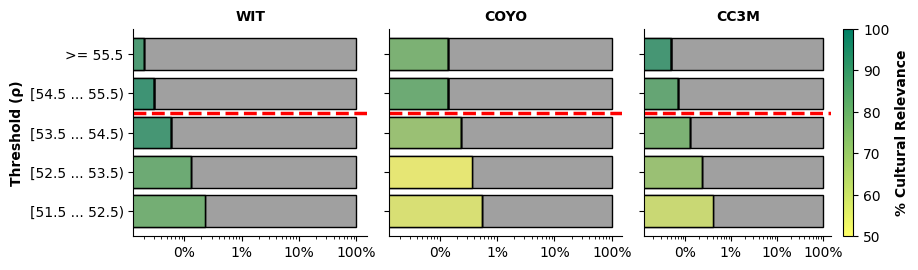

In [264]:
custom_order = {
    "[51.5 ... 52.5)": 4,
    "[52.5 ... 53.5)": 3,
    "[53.5 ... 54.5)": 2,
    "[54.5 ... 55.5)": 1,
    ">= 55.5": 0,
}
df = pd.read_csv("./data/image_filtering.csv").sort_values(
    by="threshold", key=lambda x: x.map(custom_order))

plt.figure(figsize=(12, 4))

g = sns.FacetGrid(df, col="dataset", sharex=True, sharey=True)
g.set_titles('{col_name}', fontdict={'weight': 'bold'})

# # Initialize the matplotlib figure
# f, ax = plt.subplots(figsize=(4, 3))

pdf = df

g.map_dataframe(
    sns.histplot,
    y='threshold', hue='type', hue_order=['others', 'culturally-relevant'],
    weights='image_proportion_percent', palette=["gray", "gray"],
    legend=False,
    multiple='stack', shrink=0.8
)
g.map_dataframe(
    sns.histplot,
    y='threshold', hue="relevance_percent", hue_norm=(50, 100),
    weights='image_proportion_percent',
    palette="summer_r", legend=False,
    multiple='stack', shrink=0.8,
)
g.set(
    xscale="log",
    ylabel="Threshold")
g.set_xlabels("", fontdict={'weight': 'bold'})
g.set_ylabels("Threshold (ρ)", fontdict={'weight': 'bold'})
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(ticker.PercentFormatter())

norm = plt.Normalize(50, 100)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap="summer_r", norm=norm),
    ax=plt.gca(),
)
cbar.set_label(label="% Cultural Relevance", weight='bold')

for ax in g.axes[0]:
    ax.axhline(1.5, ls='--', color='red', lw=2.5)

plt.savefig("./out/human_eval_image_filtering.pdf", bbox_inches='tight')

## Image Generation Human Eval

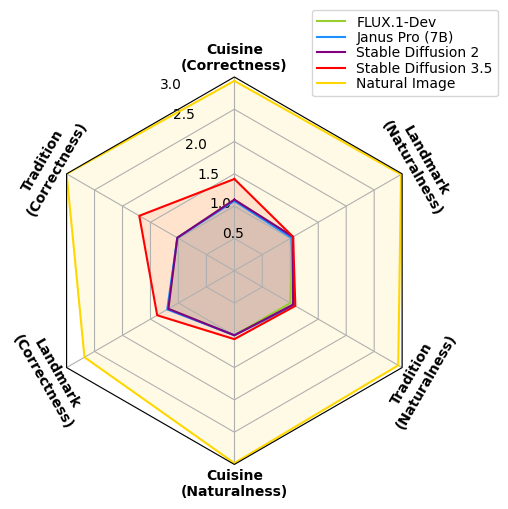

In [147]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

df = pd.read_csv("./data/image_generation.csv")

pdf = df

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.05)

    colors = ['yellowgreen', 'dodgerblue', 'purple', 'red', 'gold']
    # colors = sns.color_palette("tab10", 5)

    skills = [
        "Cuisine\n(Correctness)",
        "Tradition\n(Correctness)",
        "Landmark\n(Correctness)",
        "Cuisine\n(Naturalness)",
        "Tradition\n(Naturalness)",
        "Landmark\n(Naturalness)",
    ]
    models = [
        "FLUX.1-Dev",
        "Janus Pro (7B)",
        "Stable Diffusion 2",
        "Stable Diffusion 3.5",
        "Natural Image",
    ]
    
    for i, model in enumerate(models):
        d = pdf[pdf["model"] == model]["score"].tolist()
        color = colors[i]
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(skills)

    # thetatick_locs = np.linspace(0., 360., 7)
    thetatick_locs = [0, 60, 300, 0, 60, 300, 360]
    labels = []
    for label, angle in zip(ax.get_xticklabels(), thetatick_locs):
        x, y = label.get_position()
        lab = ax.text(x, y, label.get_text(), transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va(), fontweight='bold')
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])

    ax.set_ylim(0, 3)

    # add legend relative to top-left plot
    legend = ax.legend(models, loc=(0.7, .95),
                              labelspacing=0.1, fontsize='medium')

    plt.savefig("./out/human_eval_image_generation.pdf", bbox_inches='tight')
    plt.show()